## Load data and investigate

In [1]:
# read tsv file
import csv
import sys

# file name: subtask_a_sample.tsv

import pandas as pd

fileName = "subtask_a_train.tsv"
fileDirectory = "D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask A Train\\train"

dataA = pd.read_csv(fileDirectory + "\\" + fileName, sep='\t')

import ast
dataA['expected_order'] = dataA['expected_order'].apply(ast.literal_eval)




In [2]:
dataA.head()

,compound,subset,sentence_type,sentence,expected_order,image1_name,image1_caption,image2_name,image2_caption,image3_name,image3_caption,image4_name,image4_caption,image5_name,image5_caption
0,elbow grease,Train,idiomatic,It took a lot of elbow grease to get the old e...,"[35234427395.png, 53378381715.png, 39938261459...",35234427395.png,The image depicts a hand holding a sponge and ...,39938261459.png,The image depicts a hand wearing a yellow work...,53378381715.png,The image depicts a hand holding a duster with...,54879908369.png,The image depicts a person wearing knee pads a...,74852536462.png,The image depicts a person wearing a black out...
1,night owl,Train,idiomatic,"It's a constant battle for us, as he is a morn...","[61697797701.png, 93189810779.png, 89375227504...",00982495584.png,The image depicts a nighttime scene with a lar...,61697797701.png,The image depicts a cartoon-style illustration...,89375227504.png,The image depicts a cartoon-style owl perched ...,93189810779.png,The image depicts a cartoon-style illustration...,93541983868.png,"The image depicts a dumbbell, which is a commo..."
2,heart of gold,Train,idiomatic,Even the somewhat seedy failed private eye has...,"[86137977215.png, 78062290185.png, 54240592941...",54240592941.png,"The image depicts a large, metallic safe with ...",78062290185.png,The image depicts a joyful scene featuring a y...,86137977215.png,The image depicts a cartoon scene where a youn...,90660547751.png,"The image depicts a futuristic, stylized space...",92088849364.png,"The image depicts a stylized, artistic represe..."
3,agony aunt,Sample,idiomatic,ESA's Space Weather Office is like Europe's st...,"[83600499282.png, 57658144685.png, 02512838127...",02512838127.png,The image depicts a serene outdoor scene featu...,32964421720.png,The image depicts a cartoon-style illustration...,57658144685.png,The image depicts a scene of a person sitting ...,83600499282.png,"The image depicts a person sitting at a desk, ...",92533456778.png,The image depicts a cartoon character of a wom...
4,shrinking violet,Train,idiomatic,"This aged, rich wine is no shrinking violet wi...","[77861539717.png, 68016869942.png, 11844321898...",11844321898.png,The image depicts a bouquet of purple tulips a...,45394842176.png,"The image depicts a magnifying glass, commonly...",68016869942.png,"The image depicts a small, cute puppy standing...",77861539717.png,The image depicts an animated character with c...,97482048489.png,The image is a colorful and vibrant illustrati...


In [3]:
dataA['sentence_type'].value_counts()

idiomatic    39
literal      31
Name: sentence_type, dtype: int64

In [4]:
# functions to display images

from PIL import Image
from IPython.display import display

# Open the image file
def display_image(compound, fn):
    img = Image.open(fileDirectory + "\\" + compound + "\\" + fn)
    new_size = (150, 150)  # Width, Height
    img_resized = img.resize(new_size)  
    # Display the image
    display(img_resized)

# returns list of image names sorted from image1 to image5
def get_image_names(n,mydata):
    names = []
    for i in [1,2,3,4,5]:
         names.append(mydata['image' + str(i) + '_name'][n])
    return names


In [5]:
# print information of 1 item:

def print_item(n, mydata):
    # print  'sentence_type', 'sentence'
    compound = mydata['compound'][n]
    print(compound)
    print(mydata['sentence_type'][n])
    print(mydata['sentence'][n])
    print('---------------------------------------------------------------------')


    # for image_names in 'expected_order' print image_captions
    names  =  get_image_names(n,mydata)
    expected_order = mydata['expected_order'][n]

    for image_name in expected_order:
        display_image(compound, image_name)
        # get index of image_name in names
        index = names.index(image_name) + 1
        print(mydata['image'+str(index)+'_caption'][n])
    

top dog
literal
The top dog in the neighborhood seemed to be guarding the alley from passing cats all day.
---------------------------------------------------------------------


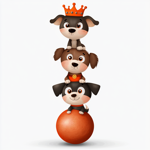

The image depicts three cartoon dogs stacked on top of each other, forming a pyramid-like structure. The dogs are illustrated in a cute and playful style.\n\n1. **Top Dog**: \n   - This dog is wearing an orange crown with a gold emblem at the center.\n   - It has brown fur with white accents around its eyes and ears.\n   - Its expression appears to be happy or content.\n\n2. **Middle Dog**:\n   - This dog is wearing a red collar with a gold emblem.\n   - It also has brown fur with white accents around its eyes and ears.\n   - Its expression is similar to the top dog, appearing happy or content.\n\n3. **Bottom Dog**:\n   - This dog is sitting on a large orange ball.\n   - It has black fur with white accents around its eyes and ears.\n   - Its expression is cheerful, with a slight smile.\n\nThe overall scene conveys a sense of balance and harmony, with each dog supporting the one above it. The use of bright colors and simple shapes makes the image visually appealing and engaging.


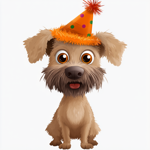

The image depicts a cartoon dog wearing an orange party hat with a pom-pom on top. The dog has a light brown coat, large brown eyes, and a black nose. It appears to be sitting and smiling, giving off a cheerful and festive vibe.


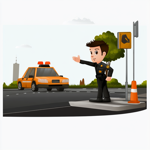

The image depicts a cartoon-style scene of a traffic officer directing traffic at an intersection. The officer is standing on a raised pedestrian crossing, wearing a black uniform with a star badge on the chest and a cap. The officer's right arm is extended, signaling vehicles to stop or proceed as needed.\n\nIn the background, there is a yellow taxi with its lights on, indicating it might be stopped or slowing down. The taxi is positioned on the left side of the image, facing towards the officer. The road is marked with white dashed lines, and there is a traffic cone placed near the officer, possibly to guide or direct traffic.\n\nTo the right of the officer, there is a pedestrian crossing sign with a symbol of a person walking, indicating that it is safe for pedestrians to cross. Behind the sign, there is a tree and some bushes, adding a touch of greenery to the scene. In the distance, there is a tall building visible, suggesting an urban setting.\n\nThe sky is clear with a few cloud

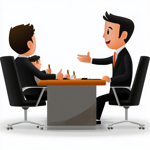

The image depicts a business meeting scenario. There are three individuals seated around a rectangular conference table. The person on the right is wearing a dark suit with an orange tie and is gesturing with his left hand, possibly explaining something to the others. The two people on the left are dressed in similar dark suits and appear to be listening attentively. They each have a pen in their hands, suggesting they might be taking notes or preparing to do so. The setting appears to be a professional office environment, indicated by the modern office chairs and the formal attire of the individuals.


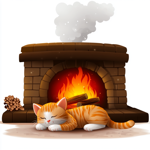

The image depicts a cozy scene featuring a brick fireplace with a warm, glowing fire burning inside. The flames are bright and orange, casting a soft light around the hearth. In front of the fireplace, there is a cute, orange tabby cat with white paws and a white face, lying down and sleeping peacefully. The cat's eyes are closed, and it appears to be enjoying the warmth of the fire. To the left of the fireplace, there is a pine cone, adding to the rustic and homely atmosphere. The overall scene conveys a sense of comfort and relaxation, typical of a cold winter day by the fireplace.


In [6]:
print_item(27,dataA)

## BERT model 

### without fine-tuning, classification of idiomatic/literal

Idea: we use a pretrained BERT model to generate embeddings of sentences and of the compound in the context of the sentence.

In [7]:
from transformers import AutoTokenizer

# model is selected from https://huggingface.co/models
checkpoint = 'bert-base-uncased' #"distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer.model_max_length

512

In [8]:
def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True)

In [9]:
demonstrate = tokenize(dataA["sentence"][:3].tolist())
for i in range(3):
    print(demonstrate["input_ids"][i])  
    print(demonstrate["attention_mask"][i])
    print(dataA["sentence"][i])
    print()


[101, 2009, 2165, 1037, 2843, 1997, 8999, 21956, 2000, 2131, 1996, 2214, 3194, 2770, 2153, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
It took a lot of elbow grease to get the old engine running again.

[101, 2009, 1005, 1055, 1037, 5377, 2645, 2005, 2149, 1010, 2004, 2002, 2003, 1037, 2851, 2711, 1998, 1045, 2572, 1037, 2305, 13547, 1010, 2061, 1045, 2424, 2008, 2183, 2000, 3637, 2012, 1023, 1012, 2382, 2428, 7659, 2041, 1996, 2190, 2847, 1012, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
It's a constant battle for us, as he is a morning person and I am a night owl, so I find that going to sleep at 9.30 really cuts out the best hours.

[101, 2130, 1996, 5399, 6534, 2100, 3478, 2797, 3239, 2038, 1037, 2540, 1997, 2751, 1006, 1998, 103

"sentence"-column is tokenized and passed to the model.

In [10]:
# tokenize all sentences
dataA_sentence_tokenized = tokenize(dataA["sentence"].tolist())

In [11]:
dataA_compound_tokenized = tokenize(dataA["compound"].tolist())

In [12]:
print(len(dataA_compound_tokenized["input_ids"][0]), len(dataA_sentence_tokenized["input_ids"][0]))
dataA_compound_tokenized["input_ids"][:3]

6 42


[[101, 8999, 21956, 102, 0, 0],
 [101, 2305, 13547, 102, 0, 0],
 [101, 2540, 1997, 2751, 102, 0]]

In [13]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint, output_hidden_states=True).to(device)
model = model.eval()


In [14]:
# convert input_ids to tensor
input_ids_sentence = torch.tensor(dataA_sentence_tokenized["input_ids"]).to(device)
attention_mask_sentence = torch.tensor(dataA_sentence_tokenized["attention_mask"]).to(device)

# pass input_ids to model
with torch.no_grad():
    output = model(input_ids_sentence, attention_mask_sentence)



In [15]:
# number of items, number of 
output.last_hidden_state.shape
# number of items, length of input_ids ,number of hidden units

torch.Size([70, 42, 768])

In [16]:
hidden_states_sentence = output.hidden_states

In [17]:
print ("Number of layers:", len(hidden_states_sentence), "  (including initial embeddings)")
layer_i = 0

print ("Number of batches:", len(hidden_states_sentence[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states_sentence[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states_sentence[layer_i][batch_i][token_i]))


Number of layers: 13   (including initial embeddings)
Number of batches: 70
Number of tokens: 42
Number of hidden units: 768


In [18]:
import numpy as np
def get_sentence_embedding(hidden_states,method):
    sentence_embedding = []
    if method == 'meanLast4': # average of all tokens of the last 4 layers
        for i in range(len(hidden_states[0])):
            # token_vecs is mean of last 4 layers
            token_tensor = torch.stack([hidden_states[-1][i], hidden_states[-2][i], hidden_states[-3][i], hidden_states[-4][i]], dim=0)
            token_vecs = torch.mean(token_tensor, dim=0)
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanSecondToLast': # average of second to last layer
        for i in range(len(hidden_states[-2])):
            token_vecs = hidden_states[-2][i]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanLast': # average of last layer
        for i in range(len(hidden_states[-1])):
            token_vecs = hidden_states[-1][i]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'lastCLS': # CLS token of last layer
        sentence_embedding = hidden_states[-1][:, 0, :]
    elif method == 'meanFirst': # average of first layer
        for i in range(len(hidden_states[0])):
            token_vecs = hidden_states[0][i]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'firstCLS': # CLS token of first layer
        sentence_embedding = hidden_states[0][:, 0, :]
    return sentence_embedding

Müsste man nicht eigentlich die Embeddings der durchs Padding hinzugefügten 0-Tokens ignorieren?

In [19]:
# use all methods for getting sentence embeddings and add them to dataA

methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst','firstCLS','lastCLS']

for method in methods:
    X = get_sentence_embedding(hidden_states_sentence,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    # add a new column to dataA 
    dataA['sentence_embedding_'+ method] = X
    



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# mlp
from sklearn.neural_network import MLPClassifier


# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


for method in methods: 
    X = dataA['sentence_embedding_'+ method].tolist()
    y = dataA["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    print('=========================================================')
    print(method)
    # logistic regression
#    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#    clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
    clf = SVC(kernel='linear').fit(X_train, y_train)
#    clf = MLPClassifier(random_state=0, max_iter=300).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(accuracy_score(y_test, y_pred))

    #classification report
    print(classification_report(y_test, y_pred,zero_division=0))



meanSecondToLast
0.9285714285714286
              precision    recall  f1-score   support

   idiomatic       0.89      1.00      0.94         8
     literal       1.00      0.83      0.91         6

    accuracy                           0.93        14
   macro avg       0.94      0.92      0.93        14
weighted avg       0.94      0.93      0.93        14

meanLast4
0.9285714285714286
              precision    recall  f1-score   support

   idiomatic       0.89      1.00      0.94         8
     literal       1.00      0.83      0.91         6

    accuracy                           0.93        14
   macro avg       0.94      0.92      0.93        14
weighted avg       0.94      0.93      0.93        14

meanLast
0.9285714285714286
              precision    recall  f1-score   support

   idiomatic       0.89      1.00      0.94         8
     literal       1.00      0.83      0.91         6

    accuracy                           0.93        14
   macro avg       0.94      0.92  

Die Ergebnisse sind erstaunlich gut. Allerdings sind sie auch sehr abhängig von random_state (teste 0,10,13,42)

In [21]:
# dummy classifier most frequent
from sklearn.dummy import DummyClassifier


# dummy classifier most frequent
clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("dummy classifier most frequent")
print(accuracy_score(y_test, y_pred))

#classification report
print(classification_report(y_test, y_pred,zero_division=0))


dummy classifier most frequent
0.5714285714285714
              precision    recall  f1-score   support

   idiomatic       0.57      1.00      0.73         8
     literal       0.00      0.00      0.00         6

    accuracy                           0.57        14
   macro avg       0.29      0.50      0.36        14
weighted avg       0.33      0.57      0.42        14



In [22]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS'],
      dtype='object')

### Compare compound embeddings in sentence and in chatGPT definitions.
#### 1) get contextualized compound embeddings for compounds in sentences

In [23]:
# sometimes the compound occurs in plural form in the sentence

# add a new column to dataA with the plural form of the compound 
dataA['compound_plural'] = dataA['compound'] + 's'
dataA_compound_plural_tokenized = tokenize(dataA["compound_plural"].tolist())

Sometimes the compound occurs in the sentence only in plural form. So both forms are needed.

In [24]:
tokenizer.tokenize("rotten apples and oranges are in the woodbasket")

['rotten',
 'apples',
 'and',
 'orange',
 '##s',
 'are',
 'in',
 'the',
 'wood',
 '##basket']

In [25]:
# returns the index of the compound in the sentence
def get_idx(compound_tokens, compound_plural_tokens, sentence_tokens):
    # remove 0-tokens from compound_tokens (removes tokens that are due to padding)
    compound_tokens = [i for i in compound_tokens if i != 0]
    # remove [CLS] and [SEP] from compound_tokens
    compound_tokens = compound_tokens[1:-1]
    compound_plural_tokens = [i for i in compound_plural_tokens if i != 0]
    compound_plural_tokens = compound_plural_tokens[1:-1]
    idx = []
    # find the first occurence of the sequence of compound_tokens in sentence_tokens (singular and plural forms)
    for i in range(len(sentence_tokens)):
        if sentence_tokens[i:i+len(compound_tokens)] == compound_tokens:
            for j in range(i, i+ len(compound_tokens)):
                idx.append(j)
    for i in range(len(sentence_tokens)):
        if sentence_tokens[i:i+len(compound_plural_tokens)] == compound_plural_tokens:
            for j in range(i, i+ len(compound_plural_tokens)):
                idx.append(j)
    # remove duplicates from idx
    idx = list(set(idx))
    return idx



In [26]:
#testen
get_idx([99,1,5,100,0,0],[99,1,5,2,100,0,0],[1,5,3,7,4,1,5,2,1,9,0,0,0])

[0, 1, 5, 6, 7]

In [27]:
hidden_states_sentence[-1].shape

torch.Size([70, 42, 768])

In [28]:
# returns the embeddings of the tokens in idxList. 
# The embeddings are combined to a single embedding by different averaging methods
import numpy as np
def get_idxList_embedding(hidden_states,idxLists,method):
    embedding = []
    if method == 'meanLast4':
        for i in range(len(hidden_states[-1])):
            # token_vecs is mean of last 4 layers
            idxList = idxLists[i]
            token_tensor = torch.stack([hidden_states[-1][i][idxList], hidden_states[-2][i][idxList], hidden_states[-3][i][idxList], hidden_states[-4][i][idxList]], dim=0)
            token_vecs = torch.mean(token_tensor, dim=0)
            embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanSecondToLast':
        for i in range(len(hidden_states[-2])):
            idxList = idxLists[i]
            token_vecs = hidden_states[-2][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanLast':
        for i in range(len(hidden_states[-1])):
            idxList = idxLists[i]
            token_vecs = hidden_states[-1][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanFirst':
        for i in range(len(hidden_states[0])):
            idxList = idxLists[i]
            token_vecs = hidden_states[0][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0))
    return embedding

In [29]:
# add column to dataA with the indices of the compound in the sentence
dataA["compound_idx"] = [get_idx(dataA_compound_tokenized["input_ids"][i], dataA_compound_plural_tokenized["input_ids"][i], dataA_sentence_tokenized["input_ids"][i]) for i in range(len(dataA))]



In [30]:
# print dataA["sentence"] if compound_idx is empty (ideally there should be no empty compound_idx)
for i in range(len(dataA)):
    if dataA["compound_idx"][i] == []:
        print(dataA["compound"][i])
        print(dataA["sentence"][i])

In [31]:

# add column compound_embedding to dataA use method 'meanLast'
compound_methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst']
for method in compound_methods:
    dataA['compound_embedding_'+ method] = get_idxList_embedding(hidden_states_sentence,dataA["compound_idx"],method) 

In [32]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS', 'compound_plural', 'compound_idx',
       'compound_embedding_meanSecondToLast', 'compound_embedding_meanLast4',
       'compound_embedding_meanLast', 'compound_embedding_meanFirst'],
      dtype='object')

compound_embedding_ enthält die Embedding des Compounds im Sentence

In [33]:
dataA['compound_embedding_meanLast'][0].shape

torch.Size([768])

#### 2) Get contextualized compound embeddings in gpt_sentences and gpt_meaning and gpt_pic embeddings


In [34]:
# read chatGPT data from csv
directory_chatGPT = "./"
#file_chatGPT = "gpt-desc-updated.csv"
file_chatGPT = "gpt-desc.csv"

data_chatGPT = pd.read_csv(directory_chatGPT + "\\" + file_chatGPT)

# rename each column with "gpt_" in front of the column name
data_chatGPT.rename(columns=lambda x: 'gpt_' + x, inplace=True)


In [35]:
data_chatGPT.columns

Index(['gpt_compound', 'gpt_sentence_type', 'gpt_Meaning', 'gpt_sentence',
       'gpt_pic_sentence'],
      dtype='object')

In [36]:
# gpt data needs some cleanup:

# replace ’ with ' in all columns
for column in data_chatGPT.columns:
    data_chatGPT[column] = data_chatGPT[column].str.replace("’","'")



In [37]:
# add a new column to dataA with the plural form of the compound
data_chatGPT['gpt_compound_plural'] = data_chatGPT['gpt_compound'] + 's'


In [38]:
# tokenize the columns gpt_sentence, gpt_Meaning, gpt_pic_sentence
gpt_sentence_tokenized = tokenize(data_chatGPT["gpt_sentence"].tolist())
gpt_Meaning_tokenized = tokenize(data_chatGPT["gpt_Meaning"].tolist())
gpt_pic_sentence_tokenized = tokenize(data_chatGPT["gpt_pic_sentence"].tolist())
gpt_compound_tokenized = tokenize(data_chatGPT["gpt_compound"].tolist())
gpt_compound_plural_tokenized = tokenize(data_chatGPT["gpt_compound_plural"].tolist())


In [39]:
# print the first 2 items of each column 
print(data_chatGPT["gpt_sentence"][0])
print(data_chatGPT["gpt_Meaning"][0])
print(data_chatGPT["gpt_pic_sentence"][0])

print(data_chatGPT["gpt_sentence"][1])
print(data_chatGPT["gpt_Meaning"][1])
print(data_chatGPT["gpt_pic_sentence"][1])



It took a lot of elbow grease to get the old engine running again.
Hard physical work or effort.
A hardworking mechanic intensely cleaning an old, rusty engine in a garage, surrounded by tools, with sweat visible on their brow, symbolizing the effort and hard work required.
The mechanic applied elbow grease to the joint to ensure it moved smoothly.
Actual grease or lubricant applied to an elbow joint.
A mechanic in a workshop applying a lubricant to an elbow joint, with a visible grease canister nearby, focused on the precise application process.


Nur in den Sätzen kommt das Compound vor. 

In [40]:
# Sentence embeddings for gpt_Meaning

# hidden states for gpt_Meaning
input_ids = torch.tensor(gpt_Meaning_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(gpt_Meaning_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_meaning = output.hidden_states

# add a columns to data_chatGPT with the embeddings of the gpt_sentence for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_meaning,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    data_chatGPT['gpt_Meaning_embedding_'+ method] = X

In [41]:
# Sentence embeddings for gpt_pic_sentence

# hidden states for gpt_pic_sentence
input_ids = torch.tensor(gpt_pic_sentence_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(gpt_pic_sentence_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_picture = output.hidden_states

# add a columns to data_chatGPT with the embeddings of the gpt_sentence for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_picture,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    data_chatGPT['gpt_pic_sentence_embedding_'+ method] = X
    

In [42]:
data_chatGPT.columns

Index(['gpt_compound', 'gpt_sentence_type', 'gpt_Meaning', 'gpt_sentence',
       'gpt_pic_sentence', 'gpt_compound_plural',
       'gpt_Meaning_embedding_meanSecondToLast',
       'gpt_Meaning_embedding_meanLast4', 'gpt_Meaning_embedding_meanLast',
       'gpt_Meaning_embedding_meanFirst', 'gpt_Meaning_embedding_firstCLS',
       'gpt_Meaning_embedding_lastCLS',
       'gpt_pic_sentence_embedding_meanSecondToLast',
       'gpt_pic_sentence_embedding_meanLast4',
       'gpt_pic_sentence_embedding_meanLast',
       'gpt_pic_sentence_embedding_meanFirst',
       'gpt_pic_sentence_embedding_firstCLS',
       'gpt_pic_sentence_embedding_lastCLS'],
      dtype='object')

In [43]:
# add column compound_embedding to data_chatGPT use methods compound_methods

# hidden states for gpt_sentence
input_ids = torch.tensor(gpt_sentence_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(gpt_sentence_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_sentence = output.hidden_states

# identify the indices of the compound in the sentence and use it to get the embeddings of the compound
data_chatGPT["gpt_compound_idx"] = [get_idx(gpt_compound_tokenized["input_ids"][i], gpt_compound_plural_tokenized["input_ids"][i], gpt_sentence_tokenized["input_ids"][i]) for i in range(len(data_chatGPT))]

In [44]:
# apply the methods in compound_methods to get the embeddings of the compound
for method in compound_methods:
    data_chatGPT['gpt_compound_embedding_'+ method] = get_idxList_embedding(hidden_states_gpt_sentence,data_chatGPT["gpt_compound_idx"],method) 

In [45]:
data_chatGPT["gpt_compound_embedding_meanLast4"][0].shape

torch.Size([768])

In [46]:
# print data_chatGPT["gpt_sentence"] if compound_idx is empty
# this is important to see what causes the empty compound_idx 
for i in range(len(data_chatGPT)):
    if data_chatGPT["gpt_compound_idx"][i] == []:
        print(i)
        print(data_chatGPT["gpt_compound"][i])
        print(data_chatGPT["gpt_sentence"][i])

3) ### Use cosine similarity between compound_embedding in dataA and in data_chatGPT to decide idiomatic/literal

In [47]:
# for each item in dataA find the corresponding items in data_chatGPT
# the corresponding item is the item with the same compound

def find_corresponding_items(dataA,data_chatGPT):
    corresponding_items = []
    for i in range(len(dataA)):
        compound = dataA['compound'][i]
        bool = data_chatGPT['gpt_compound'] == compound
        # find idx of True in bool
        idx = [i for i, x in enumerate(bool) if x]
        corresponding_items.append(idx)
    return corresponding_items

In [48]:
data_chatGPT['gpt_compound'][0]

'elbow grease'

In [49]:
compound = dataA['compound'][3]
bool = data_chatGPT['gpt_compound'] == compound

# find idx of True in bool
idx = [i for i, x in enumerate(bool) if x]

In [50]:
# get the corresponding item to idx [Dauert ewig. Gibt es eine bessere Lösung?]

data_chatGPT.iloc[idx]

,gpt_compound,gpt_sentence_type,gpt_Meaning,gpt_sentence,gpt_pic_sentence,gpt_compound_plural,gpt_Meaning_embedding_meanSecondToLast,gpt_Meaning_embedding_meanLast4,gpt_Meaning_embedding_meanLast,gpt_Meaning_embedding_meanFirst,...,gpt_pic_sentence_embedding_meanLast4,gpt_pic_sentence_embedding_meanLast,gpt_pic_sentence_embedding_meanFirst,gpt_pic_sentence_embedding_firstCLS,gpt_pic_sentence_embedding_lastCLS,gpt_compound_idx,gpt_compound_embedding_meanSecondToLast,gpt_compound_embedding_meanLast4,gpt_compound_embedding_meanLast,gpt_compound_embedding_meanFirst
6,agony aunt,idiomatic,A person or organization that offers advice an...,ESA's Space Weather Office is like Europe's st...,A cosmic-themed office setup with a person or ...,agony aunts,"[-0.14159919321537018, 0.3364521265029907, 0.1...","[-0.1098601222038269, 0.3238167464733124, 0.12...","[-0.12177998572587967, 0.2193506807088852, 0.2...","[-0.16814972460269928, 0.06925195455551147, -0...",...,"[0.13678966462612152, 0.3918343186378479, 0.20...","[0.06747637689113617, 0.25657251477241516, 0.1...","[0.017099888995289803, 0.12051121145486832, -0...","[0.16855061054229736, -0.2857673764228821, -0....","[-0.6006588339805603, -0.12249989062547684, -0...","[13, 14]","[tensor(-0.0540), tensor(-0.1183), tensor(0.56...","[tensor(0.0222), tensor(-0.1171), tensor(0.568...","[tensor(-0.0919), tensor(0.0188), tensor(0.585...","[tensor(-0.0751), tensor(-0.1166), tensor(-0.3..."
7,agony aunt,literal,A woman who gives advice or solves problems fo...,"The agony aunt sat at her desk, thoughtfully c...","A warm, cozy room with a thoughtful woman seat...",agony aunts,"[-0.22741030156612396, -0.045613378286361694, ...","[-0.2194714993238449, -0.10328776389360428, 0....","[-0.23725827038288116, -0.11049438267946243, 0...","[-0.1097341999411583, 0.1830216646194458, -0.0...",...,"[0.012248092330992222, 0.3889606297016144, 0.0...","[-0.00827939435839653, 0.23951362073421478, 0....","[0.04780123382806778, 0.32767271995544434, -0....","[0.16855061054229736, -0.2857673764228821, -0....","[-0.17640900611877441, -0.2033209204673767, -0...","[2, 3]","[tensor(0.1208), tensor(0.0220), tensor(0.4903...","[tensor(-0.0149), tensor(-0.0555), tensor(0.58...","[tensor(-0.0088), tensor(-0.0628), tensor(0.68...","[tensor(0.0062), tensor(-0.3551), tensor(-0.48..."


In [51]:
# Reduce chatGPT. Remove all embedding columns beside the ones with the method 'meanLast' and 'meanLast4

keep_columns = ['gpt_compound', 'gpt_sentence_type', 'gpt_Meaning', 'gpt_sentence',
       'gpt_pic_sentence', 
       'gpt_Meaning_embedding_meanLast4', 'gpt_Meaning_embedding_meanLast',
       'gpt_pic_sentence_embedding_meanLast4',
       'gpt_pic_sentence_embedding_meanLast',
       'gpt_compound_embedding_meanLast4', 'gpt_compound_embedding_meanLast']
# remove all columns that are not in keep_columns
#data_chatGPT = data_chatGPT[keep_columns]

In [52]:
for i in idx:
    print(data_chatGPT['gpt_sentence'][i])
    print(data_chatGPT['gpt_Meaning'][i])
    print(data_chatGPT['gpt_pic_sentence'][i])
    print('---------------------------------------------------------------------')

ESA's Space Weather Office is like Europe's stellar agony aunt, offering forecasts, advice and information for any organisation, individual or institution vulnerable to space phenomena.
A person or organization that offers advice and help to those with personal problems.
A cosmic-themed office setup with a person or representative at a desk, surrounded by futuristic monitors displaying space weather data, while concerned individuals and organizations line up or communicate remotely, seeking guidance.
---------------------------------------------------------------------
The agony aunt sat at her desk, thoughtfully composing replies to the readers' heartfelt letters seeking her advice.
A woman who gives advice or solves problems for others, often published in a column or media platform.
A warm, cozy room with a thoughtful woman seated at a wooden desk. Piles of letters and an old-fashioned typewriter are in front of her, with framed reader letters and newspaper clippings on the walls, sy

In [53]:
dataA["corresponding_gpt"] = find_corresponding_items(dataA,data_chatGPT)

In [54]:
dataA.head()

,compound,subset,sentence_type,sentence,expected_order,image1_name,image1_caption,image2_name,image2_caption,image3_name,...,sentence_embedding_meanFirst,sentence_embedding_firstCLS,sentence_embedding_lastCLS,compound_plural,compound_idx,compound_embedding_meanSecondToLast,compound_embedding_meanLast4,compound_embedding_meanLast,compound_embedding_meanFirst,corresponding_gpt
0,elbow grease,Train,idiomatic,It took a lot of elbow grease to get the old e...,"[35234427395.png, 53378381715.png, 39938261459...",35234427395.png,The image depicts a hand holding a sponge and ...,39938261459.png,The image depicts a hand wearing a yellow work...,53378381715.png,...,"[0.06868533790111542, -0.24831849336624146, -0...","[0.16855061054229736, -0.2857673764228821, -0....","[-0.0031434986740350723, 0.1451866626739502, -...",elbow greases,"[6, 7]","[tensor(1.2445), tensor(0.4941), tensor(0.2267...","[tensor(1.0906), tensor(0.3305), tensor(0.3365...","[tensor(1.0284), tensor(0.4412), tensor(0.2602...","[tensor(0.4982), tensor(0.3188), tensor(-0.256...","[0, 1]"
1,night owl,Train,idiomatic,"It's a constant battle for us, as he is a morn...","[61697797701.png, 93189810779.png, 89375227504...",00982495584.png,The image depicts a nighttime scene with a lar...,61697797701.png,The image depicts a cartoon-style illustration...,89375227504.png,...,"[-0.1467825472354889, 0.2007705569267273, -0.0...","[0.16855061054229736, -0.2857673764228821, -0....","[0.34098803997039795, 0.15176591277122498, -0....",night owls,"[20, 21]","[tensor(0.3947), tensor(0.1954), tensor(0.7019...","[tensor(0.3732), tensor(0.2188), tensor(0.5665...","[tensor(0.1653), tensor(-0.0985), tensor(0.579...","[tensor(0.2131), tensor(0.0368), tensor(-0.489...","[2, 3]"
2,heart of gold,Train,idiomatic,Even the somewhat seedy failed private eye has...,"[86137977215.png, 78062290185.png, 54240592941...",54240592941.png,"The image depicts a large, metallic safe with ...",78062290185.png,The image depicts a joyful scene featuring a y...,86137977215.png,...,"[0.025757232680916786, -0.10315004736185074, -...","[0.16855061054229736, -0.2857673764228821, -0....","[-0.3827044367790222, -0.21490302681922913, -0...",heart of golds,"[11, 12, 13]","[tensor(-0.3693), tensor(-0.0300), tensor(0.34...","[tensor(-0.3059), tensor(-0.0478), tensor(0.38...","[tensor(-0.2405), tensor(-0.1120), tensor(0.15...","[tensor(-0.1178), tensor(0.2763), tensor(-0.00...","[4, 5]"
3,agony aunt,Sample,idiomatic,ESA's Space Weather Office is like Europe's st...,"[83600499282.png, 57658144685.png, 02512838127...",02512838127.png,The image depicts a serene outdoor scene featu...,32964421720.png,The image depicts a cartoon-style illustration...,57658144685.png,...,"[-0.12844744324684143, 0.18944993615150452, -0...","[0.16855061054229736, -0.2857673764228821, -0....","[-0.475847065448761, 0.23487362265586853, 0.04...",agony aunts,"[13, 14]","[tensor(-0.0540), tensor(-0.1183), tensor(0.56...","[tensor(0.0222), tensor(-0.1171), tensor(0.568...","[tensor(-0.0919), tensor(0.0188), tensor(0.585...","[tensor(-0.0751), tensor(-0.1166), tensor(-0.3...","[6, 7]"
4,shrinking violet,Train,idiomatic,"This aged, rich wine is no shrinking violet wi...","[77861539717.png, 68016869942.png, 11844321898...",11844321898.png,The image depicts a bouquet of purple tulips a...,45394842176.png,"The image depicts a magnifying glass, commonly...",68016869942.png,...,"[-0.14041674137115479, -0.01779022626578808, -...","[0.16855061054229736, -0.2857673764228821, -0....","[-0.49911126494407654, -0.19261348247528076, 0...",shrinking violets,"[8, 9]","[tensor(0.1608), tensor(-0.8254), tensor(0.880...","[tensor(0.3068), tensor(-1.1151), tensor(0.755...","[tensor(-0.0211), tensor(-0.7274), tensor(0.82...","[tensor(-0.0349), tensor(-0.2551), tensor(-0.0...","[8, 9]"


In [55]:
data_chatGPT.columns

Index(['gpt_compound', 'gpt_sentence_type', 'gpt_Meaning', 'gpt_sentence',
       'gpt_pic_sentence', 'gpt_compound_plural',
       'gpt_Meaning_embedding_meanSecondToLast',
       'gpt_Meaning_embedding_meanLast4', 'gpt_Meaning_embedding_meanLast',
       'gpt_Meaning_embedding_meanFirst', 'gpt_Meaning_embedding_firstCLS',
       'gpt_Meaning_embedding_lastCLS',
       'gpt_pic_sentence_embedding_meanSecondToLast',
       'gpt_pic_sentence_embedding_meanLast4',
       'gpt_pic_sentence_embedding_meanLast',
       'gpt_pic_sentence_embedding_meanFirst',
       'gpt_pic_sentence_embedding_firstCLS',
       'gpt_pic_sentence_embedding_lastCLS', 'gpt_compound_idx',
       'gpt_compound_embedding_meanSecondToLast',
       'gpt_compound_embedding_meanLast4', 'gpt_compound_embedding_meanLast',
       'gpt_compound_embedding_meanFirst'],
      dtype='object')

In [56]:
i=3
idx = dataA['corresponding_gpt'][i]
compound_embedding = dataA['compound_embedding_meanLast4'][i]
gpt_compound_embedding1 = data_chatGPT['gpt_compound_embedding_meanLast4'][idx[0]]
gpt_compound_embedding2 = data_chatGPT['gpt_compound_embedding_meanLast4'][idx[1]]
#similarity1 = cosine_similarity([compound_embedding],gpt_compound_embedding1)
#similarity2 = cosine_similarity([compound_embedding],gpt_compound_embedding2)
len(gpt_compound_embedding1)

768

In [58]:
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [59]:
# for each item in dataA get the corresponding gpt_compound_embedding_meanLast4 

        
preds = []
for i in range(len(dataA)):
    idx = dataA['corresponding_gpt'][i]
    if idx == []:
        print("WArning: idx is empty")
        print(i)
    else:
        # compare cosine similarity of compound_embedding_meanLast4 and gpt_compound_embedding_meanLast4 in idx[0] and idx[1]
        # if similarity is higher take idx[0] else idx[1]
        compound_embedding = dataA['compound_embedding_meanLast4'][i].tolist()
        gpt_compound_embedding1 = data_chatGPT['gpt_compound_embedding_meanLast4'][idx[0]].tolist()
        gpt_compound_embedding2 = data_chatGPT['gpt_compound_embedding_meanLast4'][idx[1]].tolist()
        similarity1 = cosine_similarity(compound_embedding,gpt_compound_embedding1)
        similarity2 = cosine_similarity(compound_embedding,gpt_compound_embedding2)
        if similarity1 > similarity2:
            preds.append(data_chatGPT["gpt_sentence_type"][idx[0]])
        else:
            preds.append(data_chatGPT["gpt_sentence_type"][idx[1]])
dataA['pred_type_by_compound'] = preds
        

In [60]:
# check accuracy of the predictions: idiomaticity predicted by compound embedding in sentence compared to 
# compound embedding in gpt_sentence 
y = dataA["sentence_type"]
y_pred = dataA['pred_type_by_compound']
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred,zero_division=0))

0.9857142857142858
              precision    recall  f1-score   support

   idiomatic       0.97      1.00      0.99        39
     literal       1.00      0.97      0.98        31

    accuracy                           0.99        70
   macro avg       0.99      0.98      0.99        70
weighted avg       0.99      0.99      0.99        70



#### Jetzt noch compound embedding in Satz zu embeddings der BildCaptions

In [61]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS', 'compound_plural', 'compound_idx',
       'compound_embedding_meanSecondToLast', 'compound_embedding_meanLast4',
       'compound_embedding_meanLast', 'compound_embedding_meanFirst',
       'corresponding_gpt', 'pred_type_by_compound'],
      dtype='object')

In [62]:
dataA_image1_caption_tokenized = tokenize(dataA["image1_caption"].tolist())
dataA_image2_caption_tokenized = tokenize(dataA["image2_caption"].tolist())
dataA_image3_caption_tokenized = tokenize(dataA["image3_caption"].tolist())
dataA_image4_caption_tokenized = tokenize(dataA["image4_caption"].tolist())
dataA_image5_caption_tokenized = tokenize(dataA["image5_caption"].tolist())


In [ ]:
methods = ['meanLast4','lastCLS']

# hidden states for image1_caption
input_ids = torch.tensor(dataA_image1_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image1_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image1 = output.hidden_states

# add a columns to dataA with the embeddings of the image1_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image1,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image1_caption_embedding_'+ method] = X

# hidden states for image2_caption
input_ids = torch.tensor(dataA_image2_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image2_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image2 = output.hidden_states

# add a columns to dataA with the embeddings of the image2_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image2,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image2_caption_embedding_'+ method] = X

# hidden states for image3_caption
input_ids = torch.tensor(dataA_image3_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image3_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image3 = output.hidden_states

# add a columns to dataA with the embeddings of the image3_caption for each method in methods

for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image3,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image3_caption_embedding_'+ method] = X

# hidden states for image4_caption
input_ids = torch.tensor(dataA_image4_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image4_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image4 = output.hidden_states

# add a columns to dataA with the embeddings of the image4_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image4,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image4_caption_embedding_'+ method] = X

# hidden states for image5_caption
input_ids = torch.tensor(dataA_image5_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image5_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image5 = output.hidden_states

# add a columns to dataA with the embeddings of the image5_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image5,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image5_caption_embedding_'+ method] = X
    

In [ ]:
dataA.columns

In [ ]:
pred_rankings = []
for i in range(len(dataA)):
    # compare cosine similarity of each picture_caption_embedding_meanLast4 and compound_embedding_meanLast4
    compound_embedding = dataA['compound_embedding_meanLast4'][i].tolist()
    image1_caption_embedding = dataA['image1_caption_embedding_meanLast4'][i]
    image2_caption_embedding = dataA['image2_caption_embedding_meanLast4'][i]
    image3_caption_embedding = dataA['image3_caption_embedding_meanLast4'][i]
    image4_caption_embedding = dataA['image4_caption_embedding_meanLast4'][i]
    image5_caption_embedding = dataA['image5_caption_embedding_meanLast4'][i]
    similarity1 = cosine_similarity(compound_embedding,image1_caption_embedding)
    similarity2 = cosine_similarity(compound_embedding,image2_caption_embedding)
    similarity3 = cosine_similarity(compound_embedding,image3_caption_embedding)
    similarity4 = cosine_similarity(compound_embedding,image4_caption_embedding)
    similarity5 = cosine_similarity(compound_embedding,image5_caption_embedding)
    # sort the similarities
    similarities = [similarity1,similarity2,similarity3,similarity4,similarity5]
    # sort and give indices
    idx = np.argsort(similarities)
    # reverse the indices
    idx = idx[::-1]
    pred_rankings.append(idx)
dataA['pred_rankings'] = pred_rankings



In [ ]:
similarities, idx

In [ ]:
dataA["pred_rankings"][0]

In [ ]:
for i in range(len(dataA)):
    idxs = dataA['pred_rankings'][i]
    picture_names = get_image_names(i,dataA)
    # sort picture_names according to idxs
    picture_names = [picture_names[i] for i in idxs]
    dataA["pred_rankings"][i] = picture_names    


In [ ]:
get_image_names(69,dataA)

In [ ]:
dataA["pred_rankings"][69], dataA["expected_order"][69]

In [ ]:
dataA['expected_order'][0],dataA['pred_rankings'][0]

In [ ]:
def top1accuracy(pred_rankings,expected_order):
    correct = 0
    for i in range(len(pred_rankings)):
        if pred_rankings[i][0] == expected_order[i][0]:
            correct += 1
    return correct/len(pred_rankings)

In [ ]:
print(top1accuracy(dataA['pred_rankings'],dataA['expected_order']))


In [ ]:
# compute spearman correlation between expected_order and pred_rankings
from scipy.stats import spearmanr

def spearman_correlation(pred_rankings,expected_order):
    corr = []
    for i in range(len(pred_rankings)):
        corr.append(spearmanr(pred_rankings[i],expected_order[i]).correlation)
    return np.mean(corr)

print(spearman_correlation(dataA['pred_rankings'],dataA['expected_order']))



In [ ]:
#save dataA pickle
import pickle
dataA.to_pickle("dataA.pkl")
data_chatGPT.to_pickle("data_chatGPT.pkl")


Mehr in Funktionen packen. 
Bei Captions nur 2 Sätze betrachten.
Weg über idiomatic/literal und dann erst Bilder auswählen. 

## Zweistufig: (a) +/- idiomatic, (b) compare picture captions